In [13]:
import pickle
import matplotlib.pyplot as plt
import time
from utils import smart_reader, bitext_reader
from neuralibm1 import NeuralIBM1Model
from neuralibm1collocations import NeuralIBM1ModelCollocations
from neuralibm1vae import NeuralIBM1ModelVAE
import numpy as np

%matplotlib inline

Plotting code follows.

In [14]:
def plot(data, max_iter, gap, file_path, ylabel, xlabel, title, shouldShow=False, shouldSave=False):
    x_offset = 0.1
    y_offset = 0.01
    axes = plt.gca()
    axes.set_xlim([1 - x_offset, max_iter + x_offset])
    p = plt.plot([gap*(x + 1) for x in range(len(data))], data, 'o-',  markersize=4)
    plt.title(title)

    plt.ylabel(ylabel)

    plt.xlabel(xlabel)
    plt.xticks(range(gap, gap*(len(data)+1), gap))

    if shouldShow:
        plt.show()
        
    if shouldSave:
        plt.savefig(file_path + '.png', bbox_inches='tight')  
   


def plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test, loglike_label="log Likelihood"):
    
    fig = plt.figure()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    plt.subplots_adjust(wspace=0.3)
    
    fig.add_subplot(131)
    data = [ - el for el in loss]
    file_path = pref + '_loglike_' + tp
    label = loglike_label
    title = tp + " Epoch " + loglike_label
    plot(data, max_iter, gap, file_path, label, xlabel, title)

    fig.add_subplot(132)
    data = [ - el for el in loss_val]
    file_path =  pref + '_loglike_val_' + tp
    label = loglike_label
    title = tp + " Validation set " + loglike_label
    plot(data, max_iter, gap, file_path, label, xlabel, title)
    
    fig.add_subplot(133)
    data = aer_val
    file_path =  pref + '_aer_val_' + tp
    label = "AER"
    title = tp + " Validation set AER"
    plot(data, max_iter, gap, file_path, label, xlabel, title)

#     fig.add_subplot(134)
#     data = aer_test
#     file_path =  pref + '_aer_test_' + tp
#     label = "AER"
#     title = tp + " Test set AER"
#     plot(data, max_iter, gap, file_path, label, xlabel, title)
#     plt.show()

test_aers_all = []

## Introduction

Hereby we present the performance of the four neural IBM1 models we were required to train. All of them extend the original IBM1 model by also considering the previous word in the french sentence, but they do this in various ways.

All the parameters were kept the same for all models, we used the following values:
* batch_size=8  
* max_length=30
* lr = 0.001
* lr_decay = 0.0 (ADAM handles this)
* emb_dim = 64
* mlp_dim = 128

Our goal is to understand, implement and train the models, not to optimize their performance. Therefore, we do not perform any parameter optimization. If optimizing the model performance would have been the goal, we would have performed a grid search over the initial learning rate, hidden layer dimensions and number of hidden layers.

For each model, we provide plots for epoch log likelihood, validation set log likelihood and the validation set AER during training. Furthermore, we provide the test set aer for the trained models. There are also some short comments on the models and their performance. For more detailed information about the models, please see the theory notebook.

## Neural IBM1 (with additional French context)



In this IBM1 extension, the joint probability for a single french position is:
\begin{align} P_\theta(f_j|e_0^m) &= \sum_{a_j=0}^m P(a_j|m) P(f_j|e_{a_j}, f_{j-1})
\end{align}



### Concatenation

In this version, we combine the embeddings of the previous french word and the english word using concatenation.

We first trained the model using just the top 1000 vocabulary types. Although we expect a restriction like this to affect the accuracy of the model, it also makes the task computationally feasible with our setup. The results can be seen below.

Context Test set AER:0.4294733200726455


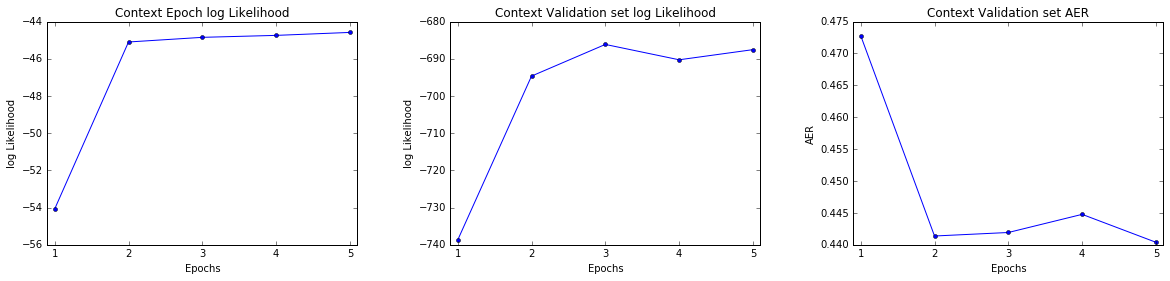

In [15]:
filename = 'stats/NeuralIBM1ContextTrainer_5e_1000v'
lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::9]
aer_val = lst[2][0::9]
loss_val = lst[1][0::9]
aer_test = lst[3][0::9]

tp = 'Context'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 5
gap = 1
plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test)

print(tp + " Test set AER:" + str(aer_test[-1]))
if not test_aers_all or aer_test[-1] not in test_aers_all:
    test_aers_all.append(aer_test[-1])

With 1000 types, the training is quickly converging as seen above. Therefore, we only show the plot for five epochs. Also, to show more insightful information, we plot the same metrics only for the first epoch. In the plot below a nice likelihood convergence curve can be seen.

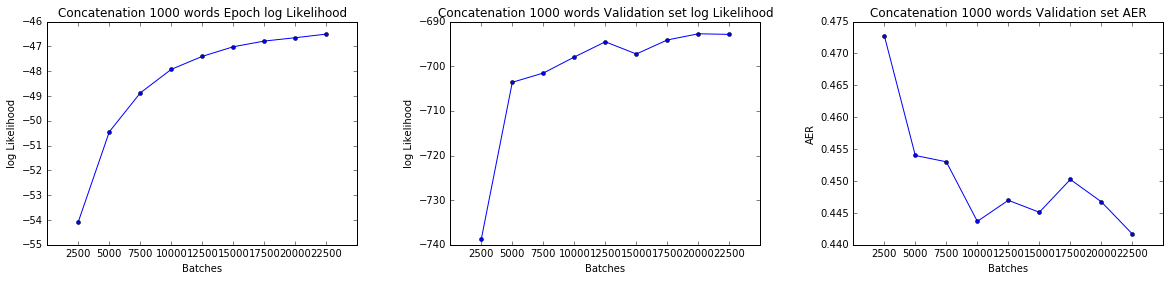

In [16]:
filename = 'stats/NeuralIBM1ContextTrainer_5e_1000v'
lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0:9]
aer_val = lst[2][0:9]
loss_val = lst[1][0:9]
aer_test = lst[3][0:9]

tp = 'Concatenation 1000 words'
pref = "iterations"
xlabel = 'Batches'
max_iter = 25000
gap = 2500

plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test)


Here the convergence is better visualized, as the cummulative improvement is visible. The improvement is also visible on the validation with the decrease of the AER and the loss.

We also trained using 4000 vocabulary words to attempt achieving better scores. The results are shown below.

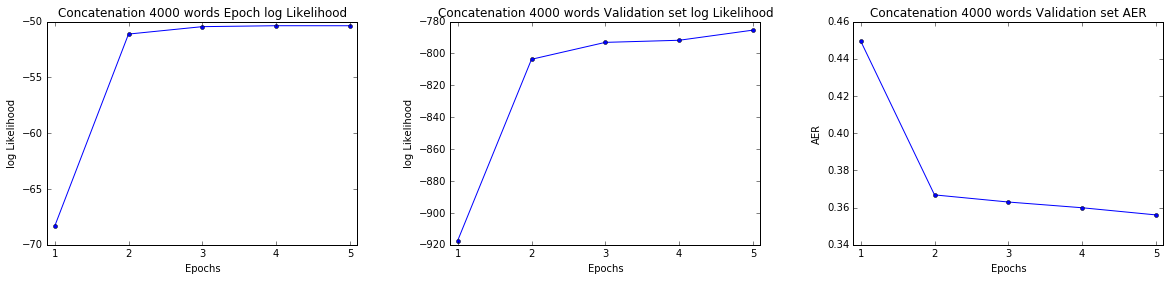

In [17]:
filename = 'stats/NeuralIBM1ContextTrainer_5e_4000v'
lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::9]
aer_val = lst[2][0::9]
loss_val = lst[1][0::9]
aer_test = lst[3][0::9]

tp = 'Concatenation 4000 words'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 5
gap = 1
plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test)

Here, as expected, we get a much better AER score on the validation set - around 0.36. This shows that the number of types is important for model performance. It is likely that the neural net would perform as well or even better than a standard IBM 1 model given the full vocabulary.

### Using a gate

In this version, the embeddings of the previous french word and the currently aligned english word are combined by a weighted sum, weighted by the gate value s, which depends solely on the previous french word. The results can be observed below:

Gate 1000 words Test set AER:0.46136133370175925


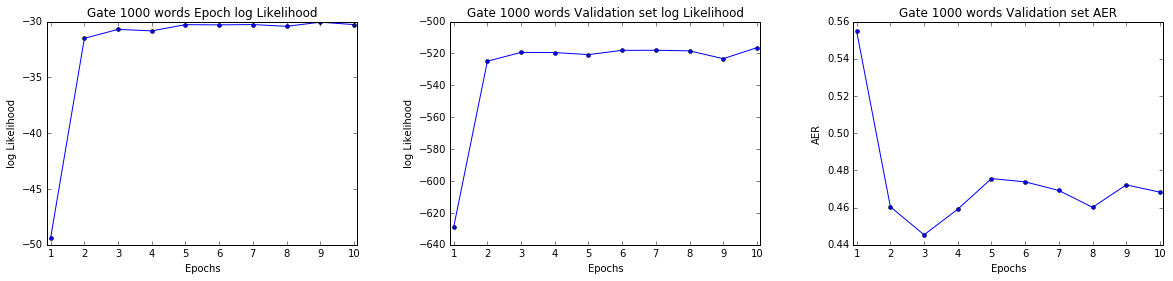

In [18]:
filename = 'stats/NeuralIBM1GateTrainer_10e_1000v'
lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::9]
aer_val = lst[2][0::9]
loss_val = lst[1][0::9]
aer_test = lst[3][0::9]

tp = 'Gate 1000 words'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 10
gap = 1
plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test)
print(tp + " Test set AER:" + str(aer_test[-1]))
if not test_aers_all or aer_test[-1] not in test_aers_all:
    test_aers_all.append(aer_test[-1])

## Neural IBM1 with collocations

We now consider a model where only one component is considered for generating each French word - either the previous French word or the an English word. The choice is made by a (binary) Bernoulli classifier.

\begin{align}
P_\theta(f_j|f_{j-1}, e_0^m) &=  \sum_{a_j=0}^m P(a_j|m) \left((1 - s_j)\times P(f_j|e_{a_j}) + s_j \times P(f_j|f_{j-1})\right)
\end{align}

The results follow:

Collocations Test set AER:0.6752475247524752


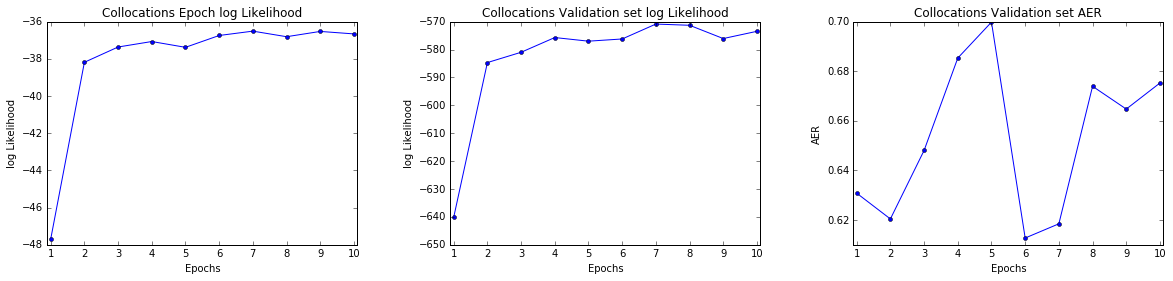

In [19]:
filename = 'stats/collocations_stats'

lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::9]
aer_val = lst[2][0::9]
loss_val = lst[1][0::9]
aer_test = lst[3][0::9]

tp = 'Collocations'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 10
gap = 1

plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test)
print(tp + " Test set AER:" + str(aer_test[-1]))
if not test_aers_all or aer_test[-1] not in test_aers_all:
    test_aers_all.append(aer_test[-1])

One can see that this model performs significantly worse in terms of validation AER compared to the previous two models which used soft assignments for generating French words. However, the log-likelihood still shows convergence. Therefore, the model probably learned to generate quite some words from the previous French word, which negatively affects the AER as those words are aligned to NULL. One can even observe this behavior in the plots. At first, the AER improves, but after the third epoch the AER suddenly worsens, indicating that the model further optimizes the log likelihood by starting to ignore more English words.

## Neural IBM1 with collocations: latent gate

In this model we take a variational approach. Here instead of two classes we consider an infinite number of classes (a continuous variable), modeled by a Beta distribution. However, this becomes intractable, forcing us to perform variational inference. Furthermore, as the Beta distribibution cannot be reparameterized, we need to approximate Beta with a simpler distribution that can, the Kuma distribution. The joint for one French words is:

\begin{align}
P(f_1^n, a_1^n, s_1^n|e_0^m) &= \prod_{j=1}^n \sum_{a_j=0}^m P(a_j|m) \int p(s_j|f_{j-1})P(f_j|e_{a_j}, f_{j-1}, s_j) \mathrm{d}s_j  \\
\end{align}

In implementing this model, some problems were encountered in computing the KL-divergence between Kuma and Beta. The KL included a term that had to be approximated by a Taylor expansion with a finite amount of terms, which could lead to negative values in the KL under certain paramater values of the Kuma and Beta distribution. To counter this, these parameters were restricted to the range [0.01, 4.01]. Still, this would sporadically lead to small negative KL values. In order to fix this, the KL per word was constrained to be bigger than zero, since this negativity is due to numerical errors and nonsensical to start with.

As implementing these 'hacks' took quite some time, we were not able to complete a full training run with a maximum sentence length of 30. Therefore, the results presented below are consrtained to a maximum sentence length of 15. These still show the convergence and AER of the model, but lead to a lower batch loss compared to the other models.

Latent Gate Test set AER:0.5250347705146037


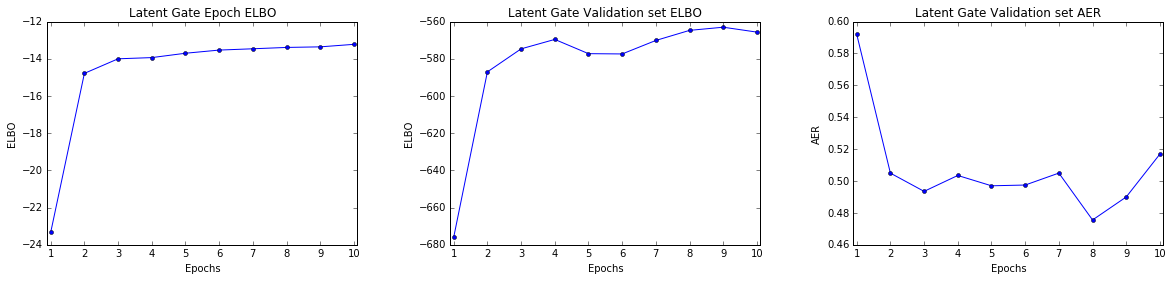

In [20]:
filename = 'stats/NeuralIBM1VAETrainer_10e_1000v'

lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::6]
aer_val = lst[2][0::6]
loss_val = lst[1][0::6]
aer_test = lst[3][0::6]

tp = 'Latent Gate'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 10
gap = 1

plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test, loglike_label="ELBO")
print(tp + " Test set AER:" + str(aer_test[-1]))
if not test_aers_all or aer_test[-1] not in test_aers_all:
    test_aers_all.append(aer_test[-1])

Below we show the same model trained with a maximum length of 30 words per sentence, for three epochs (as far as we got before the deadline). One can see that it shows convergence and AER similar to the plots above.

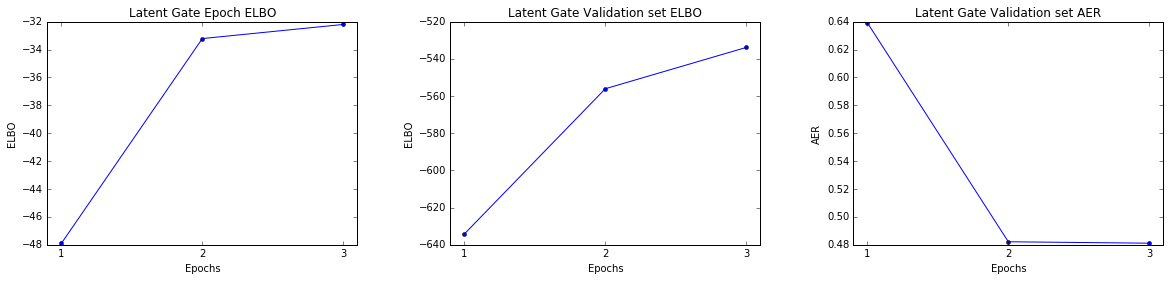

In [21]:
filename = 'stats/vae_during'

lst = pickle.load(open(filename, 'rb'))

loss = lst[0][0::9]
aer_val = lst[1][0::9]
loss_val = lst[2][0::9]
aer_test = lst[3][0::9]

tp = 'Latent Gate'
pref = "allepochs"
xlabel = 'Epochs'
max_iter = 3
gap = 1

plot_models(pref, tp, max_iter, gap, xlabel, loss, aer_val, loss_val, aer_test, loglike_label="ELBO")

## Conclusion

Finally, we show the Test Set AER of 4 of the models for comparison. Here we don't show our best model for fair comparison - it is the Concatenation model with 4000 types and gives 0.33.

From here we can conclude that the first and second, simpler, models perform best in terms of AER on the test set. The third model likely performs worse because of the hard class assignment, whilst the last model probably performs worse due to the KL computation problems.

However, when one observes the validation likelihood/ELBO in the plots above, one can see that model 3 and 4 actually convergence to a better likelihood/ELBO than the first model. Here model 2 is a clear winner, converging to the best likelihood overall. 

All in all, the models shows interesting approaches to adding context information to neural IBM1 models.

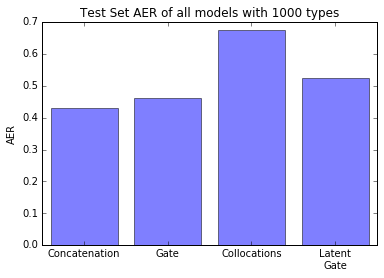

In [22]:
import numpy as np
objects = ('Concatenation','Gate', 'Collocations', 'Latent\nGate')
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, test_aers_all, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('AER')
plt.title('Test Set AER of all models with 1000 types')
 
plt.show()